<a href="https://colab.research.google.com/github/herald019/deepfake_detection/blob/main/deepfake_vit_trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
#upload the kaggle.json file
!mkdir /.kaggle
!mv kaggle.json /.kaggle
!mv /.kaggle /root/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d manjilkarki/deepfake-and-real-images

 99% 1.67G/1.68G [00:16<00:00, 119MB/s]
100% 1.68G/1.68G [00:16<00:00, 107MB/s]


In [ ]:
!unzip deepfake-and-real-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Validation/Real/real_5499.jpg  
  inflating: Dataset/Validation/Real/real_55.jpg  
  inflating: Dataset/Validation/Real/real_550.jpg  
  inflating: Dataset/Validation/Real/real_5500.jpg  
  inflating: Dataset/Validation/Real/real_5501.jpg  
  inflating: Dataset/Validation/Real/real_5502.jpg  
  inflating: Dataset/Validation/Real/real_5503.jpg  
  inflating: Dataset/Validation/Real/real_5504.jpg  
  inflating: Dataset/Validation/Real/real_5505.jpg  
  inflating: Dataset/Validation/Real/real_5506.jpg  
  inflating: Dataset/Validation/Real/real_5507.jpg  
  inflating: Dataset/Validation/Real/real_5508.jpg  
  inflating: Dataset/Validation/Real/real_5509.jpg  
  inflating: Dataset/Validation/Real/real_551.jpg  
  inflating: Dataset/Validation/Real/real_5510.jpg  
  inflating: Dataset/Validation/Real/real_5511.jpg  
  inflating: Dataset/Validation/Real/real_5512.jpg  
  inflating: Dataset/Validation/Real/real_5513.jpg  

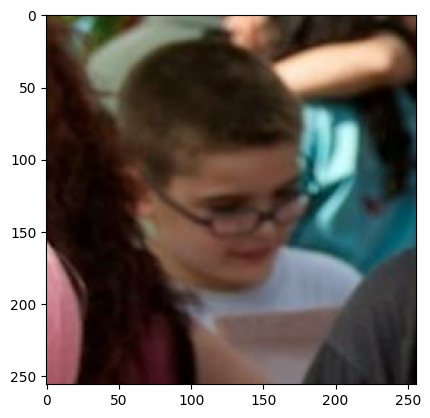

In [ ]:
from tensorflow import io
from tensorflow import image as img
from matplotlib import pyplot as plt
tensor_img = io.read_file("Dataset/Validation/Real/real_9988.jpg")
tensor_img = img.decode_png(tensor_img, channels=3)
plt.imshow(tensor_img)

In [ ]:
import tensorflow as tf
from keras import layers
import keras
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
input_shape = (64, 64, 3)
num_classes = 2
batch_size = 64
train_dir = 'Dataset/Train'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='binary')


print("Train data shape:", train_generator.image_shape)
print("Number of classes:", num_classes)

Found 140002 images belonging to 2 classes.
Train data shape: (64, 64, 3)
Number of classes: 2


In [ ]:
learning_rate = 0.0001
weight_decay = 0.0001
batch_size = 64
num_epochs = 100  # For real training, use num_epochs=100. 10 is a test value
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [
    2048,
    1024,
]

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
@keras.utils.register_keras_serializable()
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        positions = self.position_embedding(positions)
        projected_patches = self.projection(patch)
        encoded = projected_patches + positions
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches, "projection_dim": self.projection.units})
        return config

In [ ]:
@keras.utils.register_keras_serializable()
class Patches(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        input_shape = tf.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = tf.image.extract_patches(images, sizes=[1, self.patch_size, self.patch_size, 1], strides=[1, self.patch_size, self.patch_size, 1], rates=[1, 1, 1, 1], padding='VALID')
        patches = tf.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config


In [ ]:
def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    patches = Patches(patch_size)(augmented)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


In [ ]:
def run_experiment(model):
  optimizer = keras.optimizers.AdamW(
      learning_rate=learning_rate, weight_decay=weight_decay
  )

  model.compile(
      optimizer=optimizer,
      loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=[
          keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
      ],
  )

  checkpoint_filepath = "/tmp/checkpoint.weights.h5"
  checkpoint_callback = keras.callbacks.ModelCheckpoint(
      checkpoint_filepath,
      monitor="loss",
      save_best_only=True,
      save_weights_only=True,
      verbose=1,
      mode='min'
  )

  history = model.fit(
      train_generator,
      batch_size=batch_size,
      epochs=num_epochs,
      callbacks=[checkpoint_callback],
  )
  model.save('my_model.h5')
  return checkpoint_filepath



In [ ]:
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/100
  26/2188 [..............................] - ETA: 5:55 - loss: 1.5238 - accuracy: 0.5102

KeyboardInterrupt: 